In [19]:
import os
from astropy.table import Table
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

homedir=os.getenv("HOME")
path_to_dir = homedir+'/Desktop/v2-20220820/'

In [40]:
v2_main = Table.read(homedir+'/v2_snrcoadd.fits')
v2_env = Table.read(path_to_dir+'vf_v2_environment.fits')
magphys = Table.read(path_to_dir+'vf_v2_magphys_07-Jul-2022.fits')

mass = magphys['logMstar']
sfr = magphys['logSFR']
phot=Table.read(path_to_dir+'vf_v2_legacy_ephot.fits')['FLUX_AP02_W3']

mass_flag = (magphys['magphysFlag'])
clusflag = v2_env[mass_flag]['cluster_member']
snr_flag = v2_main['SNRflag']

vcosmic = v2_env['Vcosmic']

meters = (vcosmic/68)*3.08e22
flux = phot*1e-26  #W/m^2/Hz
lum = flux*(4*np.pi*meters**2)  #W/Hz

Generate a plot of W3 luminosity as a function of distance, color-coded according to stellar mass from MAGPHYS.

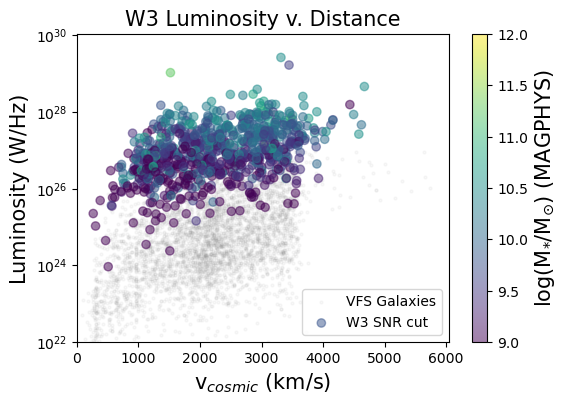

In [64]:
plt.figure(figsize=(6,4))
plt.scatter(vcosmic[mass_flag],lum[mass_flag],alpha=0.05,s=5,color='gray',label='VFS Galaxies')
plt.scatter(vcosmic[mass_flag&snr_flag],lum[mass_flag&snr_flag],alpha=0.5,c=mass[mass_flag&snr_flag],cmap='viridis',
           label='W3 SNR cut')

plt.yscale('log')
plt.xlabel(r'v$_{cosmic}$ (km/s)',fontsize=15)
plt.ylabel('Luminosity (W/Hz)',fontsize=15)
plt.title('W3 Luminosity v. Distance',fontsize=15)
cb = plt.colorbar()
plt.clim(9,12)
cb.set_label(label=r'log(M$_{*}$/M$_{\odot}$) (MAGPHYS)',size=15)
#plt.scatter(vcosmic[clusflag],lum[clusflag],facecolor='None',edgecolor='red',s=100,label='Subsample Cluster Galaxies')

plt.xlim(0,)
plt.ylim(1e22,)
plt.legend()
plt.show()

Now create a plot of MAGPHYS SFR vs. Vcosmic for all points and for those above our WISE SNR cut (i.e., do not apply our mass limit cut!). Use the lowest 5% SFR at the upper 20% of our velocity range to determine our SFR limit.

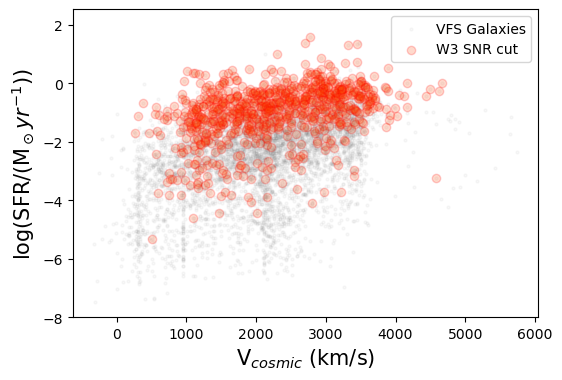

In [87]:
plt.figure(figsize=(6,4))
plt.scatter(vcosmic[mass_flag],sfr[mass_flag],alpha=0.05,s=5,color='gray',label='VFS Galaxies')
plt.scatter(vcosmic[mass_flag&snr_flag],sfr[mass_flag&snr_flag],alpha=0.2,color='orangered',
            edgecolor='red',label='W3 SNR cut')

plt.xlabel(r'V$_{cosmic}$ (km/s)',fontsize=15)
plt.ylabel(r'log(SFR/(M$_\odot yr^{-1}$))',fontsize=15)

plt.ylim(-8,)
plt.legend()
plt.show()